<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%88%98%ED%99%94%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_DNN(TTA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 수화 이미지 분류 경진대회

## 패키지 import

In [1]:
# ! pip install albumentations==0.4.6

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import warnings
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings(action = 'ignore')

In [3]:
SEED = 22
N_FOLD = 10
SAVE_PATH = './weight2'
LEARNING_RATE = 0.001
EPOCHS = 500
BATCH_SIZE = 24

In [4]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data'

/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data


In [6]:
# !unzip -o '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data/user_data.zip의 사본'

In [7]:
%cd '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류'

/content/drive/MyDrive/Dacon-Basic/수화이미지-분류


In [8]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


`-` 결측치는 없다

In [10]:
df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


`-` 파일 이름과 라벨명이 한 쌍으로 되어있음

## 데이터 셋 및 딥러닝 모델 정의

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import albumentations as A
from albumentations.pytorch import ToTensor
import gc

In [12]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
print(f'현재 device는 {device}입니다')

현재 device는 cpu입니다


In [15]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [16]:
seed_everything(SEED) ## 재현을 위한 seed 고정

- 학습 이미지와 이미지 경로

In [17]:
def load_images(path):
    images = []
    for img in sorted(glob(path + '/*.png')): ## path에 들어있는 png 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = PIL.Image.open(img)  
        img_array = np.array(an_img)  
        images.append(img_array)  
            
    images = np.array(images)
    return images

In [18]:
train_images = load_images(path='./Data/train')
test_images = load_images(path='./Data/test')

In [19]:
train_img_path_list = sorted(glob('./Data/train/*.png'))
test_img_path_list = sorted(glob('./Data/test/*.png'))

- 데이터 셋과 데이터 로더

In [20]:
class CustomDataset(Dataset):
  
    def __init__(self, images: np.array, label_list, train_mode=True, transforms=None):
        self.images = images
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image'] ## albumentations.Compose는 인자를 kwargs로 받는다

        if self.train_mode:
            label = self.label_list[idx]
            return image, label
        
        return image ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images) ## 데이터 개수 반환

- 데이터 변환

In [21]:
RGB_MEAN = [np.mean((train_images[..., i] / 255)) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[..., i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

In [54]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train_mode=True):
    transforms = A.Compose([
        A.Resize(p=1, height=128, width=128), ## 높이 128, 너비 128로 resize
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 평균을 0, 표준편차를 1로 만듦
        ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
    ])
    
    if train_mode:
        transforms = A.Compose([
            # A.CenterCrop(196, 196), ## 높이 X 너비 크기의 이미지를 중앙에서 crop
            A.Resize(p=1, height=128, width=128), ## 높이 128, 너비 128로 resize
            A.GaussNoise(p=0.5),
            # A.Blur(blur_limit=(3, 5), p=0.5),
            A.RandomBrightnessContrast(p=0.5), ## 무작위로 밝기와 대비를 조절
            A.HorizontalFlip(p=0.5), ## 50%의 확률로 수평으로 뒤집음
            A.Rotate(limit=10, p=1), ## 무작위로 -limit~limit 각도 회전
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 평균을 0, 표준편차를 1로 만듦
            ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
        ])

    return transforms ## 데이터 변환 방식을 반환

`-` 라벨을 0~10로 변환하겠다

In [23]:
def get_label_map() -> dict:
    label_map = dict()
    label_map['10-1'] = 10
    label_map['10-2'] = 0
    
    for i in range(1, 10):
        label_map[str(i)] = i

    return label_map

In [24]:
def label_encoding_transform(label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    encoded_label = label.apply(lambda x: label_map[x])
    return encoded_label

In [25]:
def label_encoding_inverse_transform(encoded_label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    label_inverse_map = dict(zip(label_map.values(), label_map.keys()))
    label = encoded_label.apply(lambda x: label_inverse_map[x])
    return label

In [26]:
target = label_encoding_transform(df['label'])

- CNN 신경망

In [27]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn_model = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(4, 4), stride=1, padding='same'), ## padding='same' 옵션을 사용할려면 stride가 1이어야 한다
            nn.ELU(),
            nn.BatchNorm2d(32),
  
            nn.Conv2d(32, 16, kernel_size=(4, 4), stride=1, padding='same'), 
            nn.ELU(), 
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, kernel_size=(4, 4), stride=1, padding='same'), 
            nn.ELU(), 
            nn.BatchNorm2d(16),

            nn.MaxPool2d(kernel_size=(4, 4), stride=2), ## max pooling

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.ELU(), 
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.ELU(), 
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.ELU(), 
            nn.BatchNorm2d(16),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.AdaptiveAvgPool2d(1) ## Flatten역할 ## 이미지를 평균내서 1*1 크기로 만든다
        )

        self.linear_model = nn.Sequential(
            nn.Linear(16, 64),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 11) ## softmax는 옵티마이저(CrossEntorpyLoss)에서 수행
        )
      
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.squeeze()
        x = self.linear_model(x)
        return x

- Linear layer 가중치 초기화

In [28]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1/np.sqrt(y))
        m.bias.data.fill_(0)

- 조기 중단

In [29]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

## 모델 교차검증

In [30]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [31]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.125)   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨, 라벨 스무딩 사용(오버피팅 방지)

In [32]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [33]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [34]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [67]:
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(train_images, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'[{i + 1} / {N_FOLD}] Fold Training......')
    
    X_train, X_valid = train_images[train_idx], train_images[valid_idx] 
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    early_stopping = EarlyStopping(patience=50,
                                   verbose=False,
                                   path=SAVE_PATH,
                                   n_fold=i+1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## CNN 모델
    net = CNN().to(device)
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=get_transform(train_mode=True))
    valid_dataset = CustomDataset(X_valid, y_valid, train_mode=True, transforms=get_transform(train_mode=False))
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## scheduler
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                               lr_lambda=lambda epoch: 0.97 ** epoch,
    #                                               last_epoch=-1,
    #                                               verbose=False)
    
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6, last_epoch=-1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)
    
    ## fold별로 모델 학습
    for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 10 == 0 or epoch == EPOCHS - 1: 
            ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 10 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits}Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits}Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')     

[1 / 10] Fold Training......


  0%|          | 1/500 [00:05<46:02,  5.54s/it]

[Epoch:   1] train loss = 2.5126  valid loss = 2.3871


  2%|▏         | 11/500 [00:58<43:15,  5.31s/it]

[Epoch:  11] train loss = 2.2487  valid loss = 2.2859


  4%|▍         | 21/500 [01:49<40:32,  5.08s/it]

[Epoch:  21] train loss = 2.0438  valid loss = 1.9509


  6%|▌         | 31/500 [02:40<39:37,  5.07s/it]

[Epoch:  31] train loss = 1.9652  valid loss = 1.9151


  8%|▊         | 41/500 [03:30<38:20,  5.01s/it]

[Epoch:  41] train loss = 1.9699  valid loss = 1.8931


 10%|█         | 51/500 [04:20<37:35,  5.02s/it]

[Epoch:  51] train loss = 1.8627  valid loss = 1.7625


 12%|█▏        | 61/500 [05:11<36:45,  5.02s/it]

[Epoch:  61] train loss = 1.7248  valid loss = 1.55


 14%|█▍        | 71/500 [06:01<36:08,  5.05s/it]

[Epoch:  71] train loss = 1.616  valid loss = 1.5199


 16%|█▌        | 81/500 [06:52<35:29,  5.08s/it]

[Epoch:  81] train loss = 1.4445  valid loss = 1.3873


 18%|█▊        | 91/500 [07:42<34:18,  5.03s/it]

[Epoch:  91] train loss = 1.4296  valid loss = 1.3568


 20%|██        | 101/500 [08:33<33:52,  5.09s/it]

[Epoch: 101] train loss = 1.448  valid loss = 1.3955


 22%|██▏       | 111/500 [09:23<32:36,  5.03s/it]

[Epoch: 111] train loss = 1.4588  valid loss = 1.387


 24%|██▍       | 121/500 [10:14<32:06,  5.08s/it]

[Epoch: 121] train loss = 1.4208  valid loss = 1.3566


 26%|██▌       | 131/500 [11:04<30:52,  5.02s/it]

[Epoch: 131] train loss = 1.3182  valid loss = 1.2426


 28%|██▊       | 141/500 [11:55<30:17,  5.06s/it]

[Epoch: 141] train loss = 1.2577  valid loss = 1.2068


 30%|███       | 151/500 [12:46<29:29,  5.07s/it]

[Epoch: 151] train loss = 1.2375  valid loss = 1.152


 32%|███▏      | 161/500 [13:36<28:27,  5.04s/it]

[Epoch: 161] train loss = 1.2307  valid loss = 1.149


 34%|███▍      | 171/500 [14:27<27:45,  5.06s/it]

[Epoch: 171] train loss = 1.2857  valid loss = 1.1942


 36%|███▌      | 181/500 [15:17<26:46,  5.04s/it]

[Epoch: 181] train loss = 1.2378  valid loss = 1.2337


 38%|███▊      | 191/500 [16:08<26:02,  5.06s/it]

[Epoch: 191] train loss = 1.1815  valid loss = 1.097


 40%|████      | 201/500 [16:58<25:19,  5.08s/it]

[Epoch: 201] train loss = 1.0989  valid loss = 1.0667


 42%|████▏     | 211/500 [17:49<24:33,  5.10s/it]

[Epoch: 211] train loss = 1.0835  valid loss = 1.0502


 44%|████▍     | 221/500 [18:40<23:26,  5.04s/it]

[Epoch: 221] train loss = 1.0945  valid loss = 1.0388


 46%|████▌     | 231/500 [19:30<22:45,  5.08s/it]

[Epoch: 231] train loss = 1.1665  valid loss = 1.1875


 48%|████▊     | 241/500 [20:21<21:45,  5.04s/it]

[Epoch: 241] train loss = 1.1775  valid loss = 1.1343


 50%|█████     | 251/500 [21:11<20:56,  5.05s/it]

[Epoch: 251] train loss = 1.1016  valid loss = 1.0471


 52%|█████▏    | 261/500 [22:01<20:02,  5.03s/it]

[Epoch: 261] train loss = 1.0255  valid loss = 1.0216


 54%|█████▍    | 271/500 [22:51<19:07,  5.01s/it]

[Epoch: 271] train loss = 1.0297  valid loss = 1.0055


 56%|█████▌    | 281/500 [23:42<18:28,  5.06s/it]

[Epoch: 281] train loss = 1.0126  valid loss = 1.0191


 58%|█████▊    | 291/500 [24:32<17:33,  5.04s/it]

[Epoch: 291] train loss = 1.0288  valid loss = 1.1238


 60%|██████    | 301/500 [25:23<16:43,  5.04s/it]

[Epoch: 301] train loss = 1.1448  valid loss = 1.0502


 62%|██████▏   | 311/500 [26:13<15:51,  5.03s/it]

[Epoch: 311] train loss = 1.0656  valid loss = 1.0865


 64%|██████▍   | 321/500 [27:03<14:55,  5.00s/it]

[Epoch: 321] train loss = 1.0205  valid loss = 0.97328


 66%|██████▌   | 331/500 [27:53<14:07,  5.02s/it]

[Epoch: 331] train loss = 0.963  valid loss = 0.96549


 68%|██████▊   | 341/500 [28:44<13:23,  5.06s/it]

[Epoch: 341] train loss = 0.98593  valid loss = 1.0007


 70%|███████   | 351/500 [29:34<12:30,  5.04s/it]

[Epoch: 351] train loss = 1.0098  valid loss = 1.0156


 72%|███████▏  | 361/500 [30:25<11:47,  5.09s/it]

[Epoch: 361] train loss = 0.99576  valid loss = 0.9719


 74%|███████▍  | 371/500 [31:15<10:53,  5.06s/it]

[Epoch: 371] train loss = 1.032  valid loss = 1.031


 76%|███████▌  | 381/500 [32:06<10:00,  5.04s/it]

[Epoch: 381] train loss = 0.94319  valid loss = 0.95807


 78%|███████▊  | 391/500 [32:56<09:08,  5.03s/it]

[Epoch: 391] train loss = 0.92057  valid loss = 0.94116


 80%|████████  | 401/500 [33:47<08:18,  5.03s/it]

[Epoch: 401] train loss = 0.93427  valid loss = 0.95887


 82%|████████▏ | 411/500 [34:37<07:24,  5.00s/it]

[Epoch: 411] train loss = 0.96096  valid loss = 0.98094


 84%|████████▍ | 421/500 [35:27<06:38,  5.04s/it]

[Epoch: 421] train loss = 1.0177  valid loss = 1.0653


 86%|████████▌ | 431/500 [36:18<05:49,  5.06s/it]

[Epoch: 431] train loss = 0.95647  valid loss = 0.96569


 88%|████████▊ | 441/500 [37:08<04:56,  5.03s/it]

[Epoch: 441] train loss = 0.91143  valid loss = 0.95243


 89%|████████▉ | 446/500 [37:38<04:33,  5.06s/it]


[Epoch: 447] train loss = 0.90504  valid loss = 0.94054
Early stopping!
1 Fold -> Best Valid Loss: 0.9216  Best Valid Accuracy: 0.8953


[2 / 10] Fold Training......


  0%|          | 1/500 [00:05<41:36,  5.00s/it]

[Epoch:   1] train loss = 2.495  valid loss = 2.403


  2%|▏         | 11/500 [00:55<40:53,  5.02s/it]

[Epoch:  11] train loss = 2.3611  valid loss = 2.3141


  4%|▍         | 21/500 [01:45<39:50,  4.99s/it]

[Epoch:  21] train loss = 2.1072  valid loss = 2.0607


  6%|▌         | 31/500 [02:35<39:29,  5.05s/it]

[Epoch:  31] train loss = 2.0255  valid loss = 1.9756


  8%|▊         | 41/500 [03:26<38:29,  5.03s/it]

[Epoch:  41] train loss = 2.0016  valid loss = 1.9241


 10%|█         | 51/500 [04:16<38:04,  5.09s/it]

[Epoch:  51] train loss = 1.9204  valid loss = 1.9826


 12%|█▏        | 61/500 [05:07<37:11,  5.08s/it]

[Epoch:  61] train loss = 1.8325  valid loss = 1.6993


 14%|█▍        | 71/500 [05:58<36:03,  5.04s/it]

[Epoch:  71] train loss = 1.6119  valid loss = 1.6053


 16%|█▌        | 81/500 [06:48<35:05,  5.02s/it]

[Epoch:  81] train loss = 1.5019  valid loss = 1.3916


 18%|█▊        | 91/500 [07:39<34:26,  5.05s/it]

[Epoch:  91] train loss = 1.5089  valid loss = 1.3271


 20%|██        | 101/500 [08:29<33:41,  5.07s/it]

[Epoch: 101] train loss = 1.4833  valid loss = 1.3328


 22%|██▏       | 111/500 [09:20<32:44,  5.05s/it]

[Epoch: 111] train loss = 1.4597  valid loss = 1.4059


 24%|██▍       | 121/500 [10:11<31:54,  5.05s/it]

[Epoch: 121] train loss = 1.4845  valid loss = 1.3795


 26%|██▌       | 131/500 [11:01<30:56,  5.03s/it]

[Epoch: 131] train loss = 1.3357  valid loss = 1.2417


 28%|██▊       | 141/500 [11:52<30:13,  5.05s/it]

[Epoch: 141] train loss = 1.2395  valid loss = 1.1218


 30%|███       | 151/500 [12:42<29:22,  5.05s/it]

[Epoch: 151] train loss = 1.1824  valid loss = 1.1347


 32%|███▏      | 161/500 [13:33<28:49,  5.10s/it]

[Epoch: 161] train loss = 1.2057  valid loss = 1.1306


 34%|███▍      | 171/500 [14:24<27:52,  5.08s/it]

[Epoch: 171] train loss = 1.2824  valid loss = 1.1712


 36%|███▌      | 181/500 [15:15<27:03,  5.09s/it]

[Epoch: 181] train loss = 1.244  valid loss = 1.2


 38%|███▊      | 191/500 [16:06<25:57,  5.04s/it]

[Epoch: 191] train loss = 1.1596  valid loss = 1.0993


 40%|████      | 201/500 [16:58<25:28,  5.11s/it]

[Epoch: 201] train loss = 1.1182  valid loss = 1.068


 42%|████▏     | 211/500 [17:48<24:05,  5.00s/it]

[Epoch: 211] train loss = 1.0727  valid loss = 1.0493


 44%|████▍     | 221/500 [18:38<23:13,  5.00s/it]

[Epoch: 221] train loss = 1.1038  valid loss = 1.0527


 46%|████▌     | 231/500 [19:28<22:31,  5.02s/it]

[Epoch: 231] train loss = 1.1796  valid loss = 1.0858


 48%|████▊     | 241/500 [20:19<21:44,  5.04s/it]

[Epoch: 241] train loss = 1.1348  valid loss = 1.1371


 50%|█████     | 251/500 [21:09<20:45,  5.00s/it]

[Epoch: 251] train loss = 1.1152  valid loss = 1.0353


 52%|█████▏    | 261/500 [21:59<19:57,  5.01s/it]

[Epoch: 261] train loss = 1.026  valid loss = 1.0069


 54%|█████▍    | 271/500 [22:49<19:14,  5.04s/it]

[Epoch: 271] train loss = 1.0202  valid loss = 0.98707


 56%|█████▌    | 281/500 [23:39<18:12,  4.99s/it]

[Epoch: 281] train loss = 1.0364  valid loss = 0.97701


 58%|█████▊    | 291/500 [24:29<17:30,  5.03s/it]

[Epoch: 291] train loss = 1.0718  valid loss = 0.9957


 60%|██████    | 301/500 [25:19<16:29,  4.97s/it]

[Epoch: 301] train loss = 1.1048  valid loss = 1.0158


 62%|██████▏   | 308/500 [25:59<16:12,  5.06s/it]


[Epoch: 309] train loss = 1.0688  valid loss = 1.1513
Early stopping!
2 Fold -> Best Valid Loss: 0.9706  Best Valid Accuracy: 0.8721


[3 / 10] Fold Training......


  0%|          | 1/500 [00:05<43:05,  5.18s/it]

[Epoch:   1] train loss = 2.5431  valid loss = 2.4165


  2%|▏         | 11/500 [00:55<41:03,  5.04s/it]

[Epoch:  11] train loss = 2.1616  valid loss = 2.1348


  4%|▍         | 21/500 [01:46<40:15,  5.04s/it]

[Epoch:  21] train loss = 1.9506  valid loss = 1.9237


  6%|▌         | 31/500 [02:36<39:26,  5.05s/it]

[Epoch:  31] train loss = 1.8976  valid loss = 1.8334


  8%|▊         | 41/500 [03:27<38:44,  5.06s/it]

[Epoch:  41] train loss = 1.9222  valid loss = 1.8684


 10%|█         | 51/500 [04:18<37:52,  5.06s/it]

[Epoch:  51] train loss = 1.8297  valid loss = 1.7801


 12%|█▏        | 61/500 [05:08<36:55,  5.05s/it]

[Epoch:  61] train loss = 1.7113  valid loss = 1.6776


 14%|█▍        | 71/500 [05:59<36:14,  5.07s/it]

[Epoch:  71] train loss = 1.5612  valid loss = 1.5347


 16%|█▌        | 81/500 [06:49<35:16,  5.05s/it]

[Epoch:  81] train loss = 1.4418  valid loss = 1.4091


 18%|█▊        | 91/500 [07:40<34:28,  5.06s/it]

[Epoch:  91] train loss = 1.4087  valid loss = 1.3343


 20%|██        | 101/500 [08:31<33:42,  5.07s/it]

[Epoch: 101] train loss = 1.3881  valid loss = 1.3311


 22%|██▏       | 111/500 [09:21<32:36,  5.03s/it]

[Epoch: 111] train loss = 1.3837  valid loss = 1.3405


 24%|██▍       | 121/500 [10:12<32:02,  5.07s/it]

[Epoch: 121] train loss = 1.3806  valid loss = 1.4


 26%|██▌       | 131/500 [11:02<31:04,  5.05s/it]

[Epoch: 131] train loss = 1.2741  valid loss = 1.1951


 28%|██▊       | 141/500 [11:53<30:20,  5.07s/it]

[Epoch: 141] train loss = 1.2142  valid loss = 1.1479


 30%|███       | 151/500 [12:44<29:31,  5.08s/it]

[Epoch: 151] train loss = 1.1391  valid loss = 1.1023


 32%|███▏      | 161/500 [13:35<28:42,  5.08s/it]

[Epoch: 161] train loss = 1.1653  valid loss = 1.113


 34%|███▍      | 171/500 [14:25<27:55,  5.09s/it]

[Epoch: 171] train loss = 1.2537  valid loss = 1.13


 36%|███▌      | 181/500 [15:16<26:54,  5.06s/it]

[Epoch: 181] train loss = 1.1911  valid loss = 1.169


 38%|███▊      | 191/500 [16:07<26:03,  5.06s/it]

[Epoch: 191] train loss = 1.1432  valid loss = 1.0869


 40%|████      | 201/500 [16:58<25:20,  5.09s/it]

[Epoch: 201] train loss = 1.0632  valid loss = 1.0801


 42%|████▏     | 211/500 [17:49<24:32,  5.09s/it]

[Epoch: 211] train loss = 1.0363  valid loss = 1.0388


 44%|████▍     | 221/500 [18:39<23:26,  5.04s/it]

[Epoch: 221] train loss = 1.0859  valid loss = 1.03


 46%|████▌     | 231/500 [19:30<22:38,  5.05s/it]

[Epoch: 231] train loss = 1.1272  valid loss = 1.0567


 48%|████▊     | 241/500 [20:20<21:56,  5.08s/it]

[Epoch: 241] train loss = 1.1371  valid loss = 1.2522


 50%|█████     | 251/500 [21:11<21:08,  5.09s/it]

[Epoch: 251] train loss = 1.109  valid loss = 1.0934


 52%|█████▏    | 259/500 [21:57<20:25,  5.09s/it]


[Epoch: 260] train loss = 1.0113  valid loss = 1.0402
Early stopping!
3 Fold -> Best Valid Loss: 1.0151  Best Valid Accuracy: 0.8488


[4 / 10] Fold Training......


  0%|          | 1/500 [00:05<42:15,  5.08s/it]

[Epoch:   1] train loss = 2.5579  valid loss = 2.3936


  2%|▏         | 11/500 [00:55<41:32,  5.10s/it]

[Epoch:  11] train loss = 2.1889  valid loss = 2.1552


  4%|▍         | 21/500 [01:46<40:16,  5.05s/it]

[Epoch:  21] train loss = 2.0135  valid loss = 1.9682


  6%|▌         | 31/500 [02:37<39:37,  5.07s/it]

[Epoch:  31] train loss = 1.9888  valid loss = 1.9115


  8%|▊         | 41/500 [03:27<38:48,  5.07s/it]

[Epoch:  41] train loss = 1.9753  valid loss = 1.8696


 10%|█         | 51/500 [04:18<37:56,  5.07s/it]

[Epoch:  51] train loss = 1.898  valid loss = 1.8187


 12%|█▏        | 61/500 [05:09<37:21,  5.11s/it]

[Epoch:  61] train loss = 1.777  valid loss = 1.7755


 14%|█▍        | 71/500 [06:00<36:11,  5.06s/it]

[Epoch:  71] train loss = 1.6079  valid loss = 1.567


 16%|█▌        | 81/500 [06:50<35:25,  5.07s/it]

[Epoch:  81] train loss = 1.505  valid loss = 1.4456


 18%|█▊        | 91/500 [07:41<34:27,  5.05s/it]

[Epoch:  91] train loss = 1.4379  valid loss = 1.465


 20%|██        | 101/500 [08:32<33:37,  5.06s/it]

[Epoch: 101] train loss = 1.4896  valid loss = 1.4698


 22%|██▏       | 111/500 [09:22<32:53,  5.07s/it]

[Epoch: 111] train loss = 1.4869  valid loss = 1.665


 24%|██▍       | 121/500 [10:13<32:07,  5.08s/it]

[Epoch: 121] train loss = 1.4657  valid loss = 1.4169


 26%|██▌       | 131/500 [11:04<31:00,  5.04s/it]

[Epoch: 131] train loss = 1.3362  valid loss = 1.3661


 28%|██▊       | 141/500 [11:54<30:22,  5.08s/it]

[Epoch: 141] train loss = 1.289  valid loss = 1.292


 30%|███       | 151/500 [12:45<29:45,  5.12s/it]

[Epoch: 151] train loss = 1.2271  valid loss = 1.2896


 32%|███▏      | 161/500 [13:36<28:43,  5.08s/it]

[Epoch: 161] train loss = 1.2432  valid loss = 1.3554


 34%|███▍      | 171/500 [14:27<27:48,  5.07s/it]

[Epoch: 171] train loss = 1.2876  valid loss = 1.3243


 36%|███▌      | 181/500 [15:18<26:55,  5.06s/it]

[Epoch: 181] train loss = 1.27  valid loss = 1.358


 38%|███▊      | 191/500 [16:08<26:05,  5.07s/it]

[Epoch: 191] train loss = 1.2452  valid loss = 1.2594


 40%|████      | 201/500 [16:59<25:13,  5.06s/it]

[Epoch: 201] train loss = 1.1525  valid loss = 1.224


 42%|████▏     | 211/500 [17:49<24:25,  5.07s/it]

[Epoch: 211] train loss = 1.1197  valid loss = 1.2269


 44%|████▍     | 221/500 [18:40<23:31,  5.06s/it]

[Epoch: 221] train loss = 1.1419  valid loss = 1.2061


 46%|████▌     | 231/500 [19:31<22:44,  5.07s/it]

[Epoch: 231] train loss = 1.2292  valid loss = 1.2451


 48%|████▊     | 241/500 [20:22<21:57,  5.09s/it]

[Epoch: 241] train loss = 1.1536  valid loss = 1.2094


 50%|█████     | 251/500 [21:13<20:59,  5.06s/it]

[Epoch: 251] train loss = 1.13  valid loss = 1.2362


 52%|█████▏    | 261/500 [22:03<20:12,  5.07s/it]

[Epoch: 261] train loss = 1.088  valid loss = 1.1745


 54%|█████▍    | 271/500 [22:54<19:27,  5.10s/it]

[Epoch: 271] train loss = 1.0546  valid loss = 1.1912


 56%|█████▌    | 281/500 [23:45<18:42,  5.13s/it]

[Epoch: 281] train loss = 1.0433  valid loss = 1.152


 58%|█████▊    | 291/500 [24:36<17:43,  5.09s/it]

[Epoch: 291] train loss = 1.0976  valid loss = 1.1937


 60%|██████    | 301/500 [25:27<16:53,  5.09s/it]

[Epoch: 301] train loss = 1.1755  valid loss = 1.324


 62%|██████▏   | 311/500 [26:18<16:00,  5.08s/it]

[Epoch: 311] train loss = 1.0592  valid loss = 1.1944


 64%|██████▍   | 321/500 [27:09<15:09,  5.08s/it]

[Epoch: 321] train loss = 1.0447  valid loss = 1.133


 66%|██████▌   | 331/500 [28:00<14:23,  5.11s/it]

[Epoch: 331] train loss = 1.0019  valid loss = 1.1398


 68%|██████▊   | 341/500 [28:51<13:29,  5.09s/it]

[Epoch: 341] train loss = 0.99718  valid loss = 1.1432


 70%|███████   | 351/500 [29:42<12:44,  5.13s/it]

[Epoch: 351] train loss = 1.0512  valid loss = 1.1509


 72%|███████▏  | 361/500 [30:33<11:43,  5.06s/it]

[Epoch: 361] train loss = 1.0959  valid loss = 1.2994


 74%|███████▍  | 371/500 [31:23<10:49,  5.03s/it]

[Epoch: 371] train loss = 1.0174  valid loss = 1.2619


 76%|███████▌  | 381/500 [32:14<10:08,  5.11s/it]

[Epoch: 381] train loss = 0.97489  valid loss = 1.0729


 78%|███████▊  | 391/500 [33:05<09:15,  5.10s/it]

[Epoch: 391] train loss = 0.96204  valid loss = 1.0692


 80%|████████  | 401/500 [33:56<08:20,  5.05s/it]

[Epoch: 401] train loss = 0.98138  valid loss = 1.1253


 82%|████████▏ | 411/500 [34:47<07:32,  5.09s/it]

[Epoch: 411] train loss = 1.0473  valid loss = 1.1828


 84%|████████▍ | 421/500 [35:38<06:39,  5.05s/it]

[Epoch: 421] train loss = 1.0818  valid loss = 1.2399


 86%|████████▌ | 431/500 [36:28<05:48,  5.05s/it]

[Epoch: 431] train loss = 1.0127  valid loss = 1.1667


 88%|████████▊ | 441/500 [37:20<05:11,  5.28s/it]

[Epoch: 441] train loss = 0.93064  valid loss = 1.1669


 90%|█████████ | 451/500 [38:11<04:08,  5.07s/it]

[Epoch: 451] train loss = 0.90743  valid loss = 1.0857


 92%|█████████▏| 461/500 [39:02<03:19,  5.11s/it]

[Epoch: 461] train loss = 0.93965  valid loss = 1.0856


 92%|█████████▏| 462/500 [39:12<03:13,  5.09s/it]


[Epoch: 463] train loss = 0.92707  valid loss = 1.163
Early stopping!
4 Fold -> Best Valid Loss: 1.0539  Best Valid Accuracy: 0.8256


[5 / 10] Fold Training......


  0%|          | 1/500 [00:05<42:28,  5.11s/it]

[Epoch:   1] train loss = 2.5076  valid loss = 2.353


  2%|▏         | 11/500 [00:55<41:19,  5.07s/it]

[Epoch:  11] train loss = 2.1622  valid loss = 2.2206


  4%|▍         | 21/500 [01:46<40:48,  5.11s/it]

[Epoch:  21] train loss = 2.0118  valid loss = 1.9713


  6%|▌         | 31/500 [02:37<39:44,  5.08s/it]

[Epoch:  31] train loss = 1.9553  valid loss = 1.9062


  8%|▊         | 41/500 [03:28<38:45,  5.07s/it]

[Epoch:  41] train loss = 1.8917  valid loss = 1.8985


 10%|█         | 51/500 [04:19<37:56,  5.07s/it]

[Epoch:  51] train loss = 1.8426  valid loss = 1.7842


 12%|█▏        | 61/500 [05:10<37:08,  5.08s/it]

[Epoch:  61] train loss = 1.7976  valid loss = 1.7234


 14%|█▍        | 71/500 [06:01<36:27,  5.10s/it]

[Epoch:  71] train loss = 1.6484  valid loss = 1.6163


 16%|█▌        | 81/500 [06:52<35:35,  5.10s/it]

[Epoch:  81] train loss = 1.5333  valid loss = 1.4983


 18%|█▊        | 91/500 [07:42<34:19,  5.04s/it]

[Epoch:  91] train loss = 1.4658  valid loss = 1.4831


 20%|██        | 101/500 [08:33<33:44,  5.07s/it]

[Epoch: 101] train loss = 1.4819  valid loss = 1.5081


 22%|██▏       | 111/500 [09:24<32:54,  5.08s/it]

[Epoch: 111] train loss = 1.4805  valid loss = 1.4981


 24%|██▍       | 121/500 [10:15<32:06,  5.08s/it]

[Epoch: 121] train loss = 1.4313  valid loss = 1.4776


 26%|██▌       | 131/500 [11:05<30:55,  5.03s/it]

[Epoch: 131] train loss = 1.3838  valid loss = 1.3504


 28%|██▊       | 141/500 [11:55<30:07,  5.03s/it]

[Epoch: 141] train loss = 1.267  valid loss = 1.2428


 30%|███       | 151/500 [12:45<29:02,  4.99s/it]

[Epoch: 151] train loss = 1.2209  valid loss = 1.2451


 32%|███▏      | 161/500 [13:37<30:34,  5.41s/it]

[Epoch: 161] train loss = 1.2205  valid loss = 1.2753


 34%|███▍      | 171/500 [14:32<28:56,  5.28s/it]

[Epoch: 171] train loss = 1.2497  valid loss = 1.2788


 36%|███▌      | 181/500 [15:22<26:51,  5.05s/it]

[Epoch: 181] train loss = 1.2244  valid loss = 1.2278


 38%|███▊      | 191/500 [16:14<27:28,  5.34s/it]

[Epoch: 191] train loss = 1.2358  valid loss = 1.2682


 40%|████      | 201/500 [17:08<25:37,  5.14s/it]

[Epoch: 201] train loss = 1.112  valid loss = 1.1294


 42%|████▏     | 211/500 [17:59<24:19,  5.05s/it]

[Epoch: 211] train loss = 1.0899  valid loss = 1.1371


 44%|████▍     | 221/500 [18:49<23:32,  5.06s/it]

[Epoch: 221] train loss = 1.1192  valid loss = 1.1329


 46%|████▌     | 231/500 [19:43<23:11,  5.17s/it]

[Epoch: 231] train loss = 1.1536  valid loss = 1.2334


 48%|████▊     | 241/500 [20:35<23:51,  5.53s/it]

[Epoch: 241] train loss = 1.1267  valid loss = 1.2534


 50%|█████     | 251/500 [21:29<21:16,  5.13s/it]

[Epoch: 251] train loss = 1.0968  valid loss = 1.138


 50%|█████     | 251/500 [21:35<21:25,  5.16s/it]

[Epoch: 252] train loss = 1.064  valid loss = 1.1558
Early stopping!
5 Fold -> Best Valid Loss: 1.1067  Best Valid Accuracy: 0.8372




[6 / 10] Fold Training......


  0%|          | 1/500 [00:07<1:05:40,  7.90s/it]

[Epoch:   1] train loss = 2.5161  valid loss = 2.4075


  2%|▏         | 11/500 [01:03<46:16,  5.68s/it]

[Epoch:  11] train loss = 2.2734  valid loss = 2.2348


  4%|▍         | 21/500 [01:58<43:23,  5.43s/it]

[Epoch:  21] train loss = 2.0868  valid loss = 1.9565


  6%|▌         | 31/500 [02:49<39:51,  5.10s/it]

[Epoch:  31] train loss = 1.9983  valid loss = 1.8663


  8%|▊         | 41/500 [03:43<39:50,  5.21s/it]

[Epoch:  41] train loss = 1.9821  valid loss = 1.84


 10%|█         | 51/500 [04:34<38:06,  5.09s/it]

[Epoch:  51] train loss = 1.887  valid loss = 1.7049


 12%|█▏        | 61/500 [05:25<36:56,  5.05s/it]

[Epoch:  61] train loss = 1.7777  valid loss = 1.6794


 14%|█▍        | 71/500 [06:17<36:36,  5.12s/it]

[Epoch:  71] train loss = 1.6649  valid loss = 1.4779


 16%|█▌        | 81/500 [07:13<38:17,  5.48s/it]

[Epoch:  81] train loss = 1.5528  valid loss = 1.4206


 18%|█▊        | 91/500 [08:03<34:24,  5.05s/it]

[Epoch:  91] train loss = 1.4995  valid loss = 1.357


 20%|██        | 101/500 [09:01<40:16,  6.06s/it]

[Epoch: 101] train loss = 1.5176  valid loss = 1.384


 22%|██▏       | 111/500 [09:51<32:55,  5.08s/it]

[Epoch: 111] train loss = 1.5469  valid loss = 1.6104


 24%|██▍       | 121/500 [10:45<36:34,  5.79s/it]

[Epoch: 121] train loss = 1.4497  valid loss = 1.4542


 26%|██▌       | 131/500 [11:39<31:37,  5.14s/it]

[Epoch: 131] train loss = 1.3831  valid loss = 1.2619


 28%|██▊       | 141/500 [12:30<30:29,  5.10s/it]

[Epoch: 141] train loss = 1.278  valid loss = 1.2605


 30%|███       | 151/500 [13:21<29:18,  5.04s/it]

[Epoch: 151] train loss = 1.2715  valid loss = 1.2383


 32%|███▏      | 161/500 [14:11<28:17,  5.01s/it]

[Epoch: 161] train loss = 1.2878  valid loss = 1.2481


 34%|███▍      | 171/500 [15:02<27:37,  5.04s/it]

[Epoch: 171] train loss = 1.3059  valid loss = 1.2655


 36%|███▌      | 181/500 [15:52<26:53,  5.06s/it]

[Epoch: 181] train loss = 1.328  valid loss = 1.3325


 38%|███▊      | 191/500 [16:43<26:01,  5.05s/it]

[Epoch: 191] train loss = 1.2412  valid loss = 1.2039


 40%|████      | 201/500 [17:33<25:11,  5.06s/it]

[Epoch: 201] train loss = 1.1613  valid loss = 1.1495


 42%|████▏     | 211/500 [18:24<24:17,  5.04s/it]

[Epoch: 211] train loss = 1.0985  valid loss = 1.1519


 44%|████▍     | 221/500 [19:14<23:24,  5.04s/it]

[Epoch: 221] train loss = 1.1408  valid loss = 1.1761


 46%|████▌     | 231/500 [20:04<22:38,  5.05s/it]

[Epoch: 231] train loss = 1.1493  valid loss = 1.2001


 48%|████▊     | 241/500 [20:55<21:38,  5.02s/it]

[Epoch: 241] train loss = 1.1741  valid loss = 1.1518


 50%|█████     | 251/500 [21:45<20:55,  5.04s/it]

[Epoch: 251] train loss = 1.1552  valid loss = 1.1172


 52%|█████▏    | 261/500 [22:36<20:11,  5.07s/it]

[Epoch: 261] train loss = 1.0424  valid loss = 1.0783


 54%|█████▍    | 271/500 [23:26<19:15,  5.05s/it]

[Epoch: 271] train loss = 1.0015  valid loss = 1.0766


 56%|█████▌    | 281/500 [24:17<18:24,  5.04s/it]

[Epoch: 281] train loss = 1.0623  valid loss = 1.0667


 58%|█████▊    | 291/500 [25:07<17:36,  5.06s/it]

[Epoch: 291] train loss = 1.0673  valid loss = 1.1766


 60%|██████    | 301/500 [25:58<16:48,  5.07s/it]

[Epoch: 301] train loss = 1.0725  valid loss = 1.1247


 62%|██████▏   | 311/500 [26:49<15:54,  5.05s/it]

[Epoch: 311] train loss = 1.0563  valid loss = 1.0851


 64%|██████▍   | 321/500 [27:39<15:07,  5.07s/it]

[Epoch: 321] train loss = 1.001  valid loss = 1.0566


 66%|██████▌   | 331/500 [28:30<14:17,  5.07s/it]

[Epoch: 331] train loss = 0.96822  valid loss = 1.0479


 68%|██████▊   | 341/500 [29:20<13:26,  5.07s/it]

[Epoch: 341] train loss = 0.98131  valid loss = 1.0801


 70%|███████   | 351/500 [30:11<12:34,  5.06s/it]

[Epoch: 351] train loss = 0.99923  valid loss = 1.0897


 72%|███████▏  | 361/500 [31:01<11:44,  5.07s/it]

[Epoch: 361] train loss = 1.0279  valid loss = 1.012


 74%|███████▍  | 371/500 [31:52<10:50,  5.05s/it]

[Epoch: 371] train loss = 1.0225  valid loss = 1.0897


 76%|███████▌  | 381/500 [32:43<09:59,  5.04s/it]

[Epoch: 381] train loss = 0.96744  valid loss = 1.0548


 78%|███████▊  | 391/500 [33:33<09:10,  5.05s/it]

[Epoch: 391] train loss = 0.92196  valid loss = 0.97415


 80%|████████  | 401/500 [34:23<08:17,  5.03s/it]

[Epoch: 401] train loss = 0.92142  valid loss = 1.0101


 82%|████████▏ | 411/500 [35:13<07:25,  5.00s/it]

[Epoch: 411] train loss = 1.0106  valid loss = 1.052


 84%|████████▍ | 421/500 [36:03<06:36,  5.02s/it]

[Epoch: 421] train loss = 0.98221  valid loss = 1.0936


 86%|████████▌ | 431/500 [36:53<05:44,  5.00s/it]

[Epoch: 431] train loss = 0.9577  valid loss = 1.0935


 88%|████████▊ | 441/500 [37:44<04:56,  5.02s/it]

[Epoch: 441] train loss = 0.91677  valid loss = 1.0062


 90%|█████████ | 451/500 [38:34<04:05,  5.01s/it]

[Epoch: 451] train loss = 0.88687  valid loss = 1.0045


 92%|█████████▏| 461/500 [39:24<03:15,  5.01s/it]

[Epoch: 461] train loss = 0.89293  valid loss = 0.99987


 94%|█████████▍| 471/500 [40:14<02:26,  5.05s/it]

[Epoch: 471] train loss = 0.94976  valid loss = 0.99451


 96%|█████████▌| 481/500 [41:05<01:35,  5.03s/it]

[Epoch: 481] train loss = 0.97648  valid loss = 1.0861


 98%|█████████▊| 491/500 [41:55<00:44,  4.99s/it]

[Epoch: 491] train loss = 0.92964  valid loss = 1.0245


100%|██████████| 500/500 [42:40<00:00,  5.12s/it]


[Epoch: 500] train loss = 0.88041  valid loss = 0.96746
6 Fold -> Best Valid Loss: 0.9482  Best Valid Accuracy: 0.9070


[7 / 10] Fold Training......


  0%|          | 1/500 [00:05<42:51,  5.15s/it]

[Epoch:   1] train loss = 2.5208  valid loss = 2.3994


  2%|▏         | 11/500 [00:55<41:11,  5.06s/it]

[Epoch:  11] train loss = 2.3413  valid loss = 2.3476


  4%|▍         | 21/500 [01:46<40:37,  5.09s/it]

[Epoch:  21] train loss = 2.1241  valid loss = 2.0871


  6%|▌         | 31/500 [02:37<39:39,  5.07s/it]

[Epoch:  31] train loss = 2.0598  valid loss = 2.0158


  8%|▊         | 41/500 [03:27<38:32,  5.04s/it]

[Epoch:  41] train loss = 2.0186  valid loss = 2.034


 10%|█         | 51/500 [04:18<37:53,  5.06s/it]

[Epoch:  51] train loss = 1.9405  valid loss = 1.9113


 12%|█▏        | 61/500 [05:08<37:10,  5.08s/it]

[Epoch:  61] train loss = 1.7525  valid loss = 1.8006


 14%|█▍        | 71/500 [05:59<36:19,  5.08s/it]

[Epoch:  71] train loss = 1.633  valid loss = 1.6643


 16%|█▌        | 81/500 [06:50<35:27,  5.08s/it]

[Epoch:  81] train loss = 1.4898  valid loss = 1.5113


 18%|█▊        | 91/500 [07:40<34:41,  5.09s/it]

[Epoch:  91] train loss = 1.4573  valid loss = 1.4762


 20%|██        | 101/500 [08:31<33:37,  5.06s/it]

[Epoch: 101] train loss = 1.4781  valid loss = 1.4946


 22%|██▏       | 111/500 [09:21<32:47,  5.06s/it]

[Epoch: 111] train loss = 1.5118  valid loss = 1.6008


 24%|██▍       | 121/500 [10:12<32:06,  5.08s/it]

[Epoch: 121] train loss = 1.4071  valid loss = 1.4125


 26%|██▌       | 131/500 [11:03<31:09,  5.07s/it]

[Epoch: 131] train loss = 1.3234  valid loss = 1.411


 28%|██▊       | 141/500 [11:54<30:13,  5.05s/it]

[Epoch: 141] train loss = 1.2806  valid loss = 1.2865


 30%|███       | 151/500 [12:44<29:19,  5.04s/it]

[Epoch: 151] train loss = 1.2239  valid loss = 1.2452


 32%|███▏      | 161/500 [13:34<28:24,  5.03s/it]

[Epoch: 161] train loss = 1.21  valid loss = 1.3018


 34%|███▍      | 171/500 [14:24<27:30,  5.02s/it]

[Epoch: 171] train loss = 1.2808  valid loss = 1.3492


 36%|███▌      | 181/500 [15:15<27:02,  5.09s/it]

[Epoch: 181] train loss = 1.2803  valid loss = 1.2684


 38%|███▊      | 191/500 [16:06<26:02,  5.06s/it]

[Epoch: 191] train loss = 1.1926  valid loss = 1.2013


 40%|████      | 201/500 [16:56<25:10,  5.05s/it]

[Epoch: 201] train loss = 1.1139  valid loss = 1.233


 42%|████▏     | 211/500 [17:47<24:23,  5.06s/it]

[Epoch: 211] train loss = 1.1016  valid loss = 1.1725


 44%|████▍     | 221/500 [18:38<23:27,  5.04s/it]

[Epoch: 221] train loss = 1.121  valid loss = 1.1756


 46%|████▌     | 231/500 [19:28<22:47,  5.08s/it]

[Epoch: 231] train loss = 1.151  valid loss = 1.3209


 48%|████▊     | 241/500 [20:19<21:57,  5.09s/it]

[Epoch: 241] train loss = 1.1784  valid loss = 1.1747


 50%|█████     | 251/500 [21:10<21:00,  5.06s/it]

[Epoch: 251] train loss = 1.0737  valid loss = 1.2068


 52%|█████▏    | 261/500 [22:00<20:10,  5.07s/it]

[Epoch: 261] train loss = 1.0401  valid loss = 1.1521


 54%|█████▍    | 271/500 [22:51<19:06,  5.01s/it]

[Epoch: 271] train loss = 1.0387  valid loss = 1.1304


 56%|█████▌    | 281/500 [23:41<18:31,  5.08s/it]

[Epoch: 281] train loss = 1.0132  valid loss = 1.1128


 58%|█████▊    | 291/500 [24:32<17:47,  5.11s/it]

[Epoch: 291] train loss = 1.0576  valid loss = 1.1982


 60%|██████    | 301/500 [25:23<16:52,  5.09s/it]

[Epoch: 301] train loss = 1.0705  valid loss = 1.1734


 62%|██████▏   | 311/500 [26:14<15:57,  5.07s/it]

[Epoch: 311] train loss = 0.98832  valid loss = 1.0954


 64%|██████▍   | 321/500 [27:04<15:04,  5.05s/it]

[Epoch: 321] train loss = 0.94718  valid loss = 1.0645


 66%|██████▌   | 331/500 [27:54<14:09,  5.02s/it]

[Epoch: 331] train loss = 0.94233  valid loss = 1.143


 68%|██████▊   | 341/500 [28:45<13:19,  5.03s/it]

[Epoch: 341] train loss = 0.96417  valid loss = 1.1208


 70%|███████   | 351/500 [29:35<12:32,  5.05s/it]

[Epoch: 351] train loss = 1.0339  valid loss = 1.0725


 72%|███████▏  | 361/500 [30:25<11:37,  5.02s/it]

[Epoch: 361] train loss = 1.024  valid loss = 1.1574


 74%|███████▍  | 371/500 [31:15<10:50,  5.04s/it]

[Epoch: 371] train loss = 0.99433  valid loss = 1.1183


 76%|███████▌  | 381/500 [32:06<09:59,  5.03s/it]

[Epoch: 381] train loss = 0.9816  valid loss = 1.0546


 78%|███████▊  | 391/500 [32:56<09:09,  5.04s/it]

[Epoch: 391] train loss = 0.91908  valid loss = 1.0278


 80%|████████  | 401/500 [33:47<08:20,  5.06s/it]

[Epoch: 401] train loss = 0.91547  valid loss = 1.0658


 82%|████████▏ | 411/500 [34:38<07:29,  5.05s/it]

[Epoch: 411] train loss = 0.95312  valid loss = 1.1481


 84%|████████▍ | 421/500 [35:29<06:41,  5.09s/it]

[Epoch: 421] train loss = 0.97651  valid loss = 1.0644


 85%|████████▍ | 423/500 [35:44<06:30,  5.07s/it]


[Epoch: 424] train loss = 0.97643  valid loss = 1.0865
Early stopping!
7 Fold -> Best Valid Loss: 1.0214  Best Valid Accuracy: 0.9070


[8 / 10] Fold Training......


  0%|          | 1/500 [00:05<42:42,  5.14s/it]

[Epoch:   1] train loss = 2.5113  valid loss = 2.3852


  2%|▏         | 11/500 [00:55<41:20,  5.07s/it]

[Epoch:  11] train loss = 2.1955  valid loss = 2.1915


  4%|▍         | 21/500 [01:46<40:44,  5.10s/it]

[Epoch:  21] train loss = 2.0176  valid loss = 1.9708


  6%|▌         | 31/500 [02:37<39:50,  5.10s/it]

[Epoch:  31] train loss = 1.9478  valid loss = 1.9524


  8%|▊         | 41/500 [03:29<39:12,  5.13s/it]

[Epoch:  41] train loss = 1.911  valid loss = 1.908


 10%|█         | 51/500 [04:19<37:44,  5.04s/it]

[Epoch:  51] train loss = 1.8387  valid loss = 1.9871


 12%|█▏        | 61/500 [05:10<37:04,  5.07s/it]

[Epoch:  61] train loss = 1.7594  valid loss = 1.78


 14%|█▍        | 71/500 [06:01<36:14,  5.07s/it]

[Epoch:  71] train loss = 1.5641  valid loss = 1.5639


 16%|█▌        | 81/500 [06:51<35:37,  5.10s/it]

[Epoch:  81] train loss = 1.4671  valid loss = 1.4375


 18%|█▊        | 91/500 [07:42<34:38,  5.08s/it]

[Epoch:  91] train loss = 1.4044  valid loss = 1.4077


 20%|██        | 101/500 [08:33<33:52,  5.09s/it]

[Epoch: 101] train loss = 1.4225  valid loss = 1.4423


 22%|██▏       | 111/500 [09:24<32:47,  5.06s/it]

[Epoch: 111] train loss = 1.4118  valid loss = 1.4301


 24%|██▍       | 121/500 [10:15<32:02,  5.07s/it]

[Epoch: 121] train loss = 1.3664  valid loss = 1.3089


 26%|██▌       | 131/500 [11:05<31:09,  5.07s/it]

[Epoch: 131] train loss = 1.2778  valid loss = 1.2623


 28%|██▊       | 141/500 [11:56<30:28,  5.09s/it]

[Epoch: 141] train loss = 1.1901  valid loss = 1.2083


 30%|███       | 151/500 [12:47<29:36,  5.09s/it]

[Epoch: 151] train loss = 1.1467  valid loss = 1.1561


 32%|███▏      | 161/500 [13:38<28:45,  5.09s/it]

[Epoch: 161] train loss = 1.1533  valid loss = 1.1827


 34%|███▍      | 171/500 [14:29<27:55,  5.09s/it]

[Epoch: 171] train loss = 1.2526  valid loss = 1.2937


 36%|███▌      | 181/500 [15:20<27:02,  5.09s/it]

[Epoch: 181] train loss = 1.2283  valid loss = 1.2686


 38%|███▊      | 191/500 [16:11<26:05,  5.07s/it]

[Epoch: 191] train loss = 1.1317  valid loss = 1.2087


 40%|████      | 201/500 [17:01<25:26,  5.11s/it]

[Epoch: 201] train loss = 1.0443  valid loss = 1.1201


 42%|████▏     | 211/500 [17:52<24:30,  5.09s/it]

[Epoch: 211] train loss = 1.0466  valid loss = 1.0874


 44%|████▍     | 221/500 [18:43<23:36,  5.08s/it]

[Epoch: 221] train loss = 1.062  valid loss = 1.0675


 46%|████▌     | 231/500 [19:34<22:42,  5.07s/it]

[Epoch: 231] train loss = 1.0583  valid loss = 1.1564


 48%|████▊     | 241/500 [20:24<21:54,  5.08s/it]

[Epoch: 241] train loss = 1.1504  valid loss = 1.1502


 50%|█████     | 251/500 [21:15<21:04,  5.08s/it]

[Epoch: 251] train loss = 1.0776  valid loss = 1.1055


 52%|█████▏    | 261/500 [22:07<20:26,  5.13s/it]

[Epoch: 261] train loss = 1.0124  valid loss = 1.0736


 54%|█████▍    | 271/500 [22:58<19:27,  5.10s/it]

[Epoch: 271] train loss = 0.98905  valid loss = 1.0392


 56%|█████▌    | 281/500 [23:49<18:36,  5.10s/it]

[Epoch: 281] train loss = 0.9952  valid loss = 1.0551


 58%|█████▊    | 291/500 [24:40<17:51,  5.13s/it]

[Epoch: 291] train loss = 1.0473  valid loss = 1.1335


 60%|██████    | 301/500 [25:32<16:59,  5.12s/it]

[Epoch: 301] train loss = 1.0744  valid loss = 1.0554


 62%|██████▏   | 311/500 [26:23<16:04,  5.10s/it]

[Epoch: 311] train loss = 1.0083  valid loss = 1.0883


 64%|██████▍   | 321/500 [27:14<15:12,  5.10s/it]

[Epoch: 321] train loss = 0.96098  valid loss = 1.0239


 66%|██████▌   | 331/500 [28:05<14:21,  5.10s/it]

[Epoch: 331] train loss = 0.92072  valid loss = 1.0186


 68%|██████▊   | 341/500 [28:56<13:29,  5.09s/it]

[Epoch: 341] train loss = 0.94348  valid loss = 1.0063


 70%|███████   | 351/500 [29:47<12:43,  5.12s/it]

[Epoch: 351] train loss = 0.98679  valid loss = 1.0676


 72%|███████▏  | 361/500 [30:38<11:46,  5.08s/it]

[Epoch: 361] train loss = 1.0461  valid loss = 1.1194


 74%|███████▍  | 371/500 [31:29<10:52,  5.06s/it]

[Epoch: 371] train loss = 0.95825  valid loss = 1.0657


 76%|███████▌  | 381/500 [32:20<10:02,  5.07s/it]

[Epoch: 381] train loss = 0.91646  valid loss = 1.0185


 78%|███████▊  | 391/500 [33:11<09:15,  5.10s/it]

[Epoch: 391] train loss = 0.90242  valid loss = 0.99338


 80%|████████  | 401/500 [34:02<08:23,  5.08s/it]

[Epoch: 401] train loss = 0.91941  valid loss = 1.0137


 82%|████████▏ | 411/500 [34:53<07:29,  5.05s/it]

[Epoch: 411] train loss = 0.95631  valid loss = 1.0448


 84%|████████▍ | 421/500 [35:44<06:42,  5.09s/it]

[Epoch: 421] train loss = 0.97069  valid loss = 1.0488


 86%|████████▌ | 431/500 [36:34<05:51,  5.09s/it]

[Epoch: 431] train loss = 0.93339  valid loss = 1.0441


 88%|████████▊ | 439/500 [37:20<05:11,  5.10s/it]

[Epoch: 440] train loss = 0.88879  valid loss = 0.97271
Early stopping!
8 Fold -> Best Valid Loss: 0.9684  Best Valid Accuracy: 0.9070


[9 / 10] Fold Training......



  0%|          | 1/500 [00:05<47:09,  5.67s/it]

[Epoch:   1] train loss = 2.5465  valid loss = 2.3677


  2%|▏         | 11/500 [00:56<41:40,  5.11s/it]

[Epoch:  11] train loss = 2.249  valid loss = 2.1725


  4%|▍         | 21/500 [01:47<40:44,  5.10s/it]

[Epoch:  21] train loss = 2.0801  valid loss = 2.0377


  6%|▌         | 31/500 [02:38<40:06,  5.13s/it]

[Epoch:  31] train loss = 2.0215  valid loss = 1.9896


  8%|▊         | 41/500 [03:29<38:53,  5.08s/it]

[Epoch:  41] train loss = 2.028  valid loss = 1.9557


 10%|█         | 51/500 [04:21<38:21,  5.12s/it]

[Epoch:  51] train loss = 1.937  valid loss = 1.9384


 12%|█▏        | 61/500 [05:12<37:19,  5.10s/it]

[Epoch:  61] train loss = 1.8185  valid loss = 1.8264


 14%|█▍        | 71/500 [06:03<36:21,  5.09s/it]

[Epoch:  71] train loss = 1.6624  valid loss = 1.4992


 16%|█▌        | 81/500 [06:53<35:31,  5.09s/it]

[Epoch:  81] train loss = 1.488  valid loss = 1.414


 18%|█▊        | 91/500 [07:44<34:47,  5.10s/it]

[Epoch:  91] train loss = 1.4591  valid loss = 1.3838


 20%|██        | 101/500 [08:35<33:45,  5.08s/it]

[Epoch: 101] train loss = 1.4737  valid loss = 1.3742


 22%|██▏       | 111/500 [09:26<32:36,  5.03s/it]

[Epoch: 111] train loss = 1.4993  valid loss = 1.4393


 24%|██▍       | 121/500 [10:16<32:00,  5.07s/it]

[Epoch: 121] train loss = 1.4238  valid loss = 1.6182


 26%|██▌       | 131/500 [11:07<31:08,  5.06s/it]

[Epoch: 131] train loss = 1.3613  valid loss = 1.3335


 28%|██▊       | 141/500 [11:57<30:18,  5.06s/it]

[Epoch: 141] train loss = 1.2119  valid loss = 1.1946


 30%|███       | 151/500 [12:48<29:42,  5.11s/it]

[Epoch: 151] train loss = 1.1972  valid loss = 1.1894


 32%|███▏      | 161/500 [13:39<28:37,  5.07s/it]

[Epoch: 161] train loss = 1.2066  valid loss = 1.2405


 34%|███▍      | 171/500 [14:29<27:52,  5.08s/it]

[Epoch: 171] train loss = 1.2277  valid loss = 1.2522


 36%|███▌      | 181/500 [15:20<27:04,  5.09s/it]

[Epoch: 181] train loss = 1.1783  valid loss = 1.2372


 38%|███▊      | 191/500 [16:11<26:14,  5.10s/it]

[Epoch: 191] train loss = 1.1524  valid loss = 1.1553


 40%|████      | 201/500 [17:02<25:15,  5.07s/it]

[Epoch: 201] train loss = 1.0754  valid loss = 1.1711


 42%|████▏     | 211/500 [17:53<24:31,  5.09s/it]

[Epoch: 211] train loss = 1.0333  valid loss = 1.1048


 44%|████▍     | 221/500 [18:43<23:25,  5.04s/it]

[Epoch: 221] train loss = 1.0589  valid loss = 1.1569


 46%|████▌     | 231/500 [19:34<22:37,  5.05s/it]

[Epoch: 231] train loss = 1.134  valid loss = 1.2325


 48%|████▊     | 241/500 [20:24<21:43,  5.03s/it]

[Epoch: 241] train loss = 1.1109  valid loss = 1.2867


 50%|█████     | 251/500 [21:15<20:56,  5.05s/it]

[Epoch: 251] train loss = 1.0489  valid loss = 1.1387


 52%|█████▏    | 261/500 [22:05<20:14,  5.08s/it]

[Epoch: 261] train loss = 0.99497  valid loss = 1.0589


 54%|█████▍    | 271/500 [22:56<19:20,  5.07s/it]

[Epoch: 271] train loss = 0.98539  valid loss = 1.0704


 56%|█████▌    | 281/500 [23:47<18:24,  5.04s/it]

[Epoch: 281] train loss = 0.99286  valid loss = 1.0724


 58%|█████▊    | 291/500 [24:37<17:28,  5.02s/it]

[Epoch: 291] train loss = 1.0228  valid loss = 1.3613


 60%|██████    | 301/500 [25:27<16:44,  5.05s/it]

[Epoch: 301] train loss = 1.0575  valid loss = 1.1837


 62%|██████▏   | 311/500 [26:18<15:57,  5.07s/it]

[Epoch: 311] train loss = 0.98881  valid loss = 1.2528


 64%|██████▍   | 321/500 [27:08<15:00,  5.03s/it]

[Epoch: 321] train loss = 0.94439  valid loss = 1.0517


 66%|██████▌   | 331/500 [27:59<14:14,  5.05s/it]

[Epoch: 331] train loss = 0.93235  valid loss = 1.0222


 68%|██████▊   | 341/500 [28:49<13:21,  5.04s/it]

[Epoch: 341] train loss = 0.94042  valid loss = 1.0726


 70%|███████   | 351/500 [29:40<12:35,  5.07s/it]

[Epoch: 351] train loss = 0.97316  valid loss = 1.0826


 72%|███████▏  | 361/500 [30:30<11:40,  5.04s/it]

[Epoch: 361] train loss = 0.97224  valid loss = 1.1061


 74%|███████▍  | 371/500 [31:21<10:52,  5.06s/it]

[Epoch: 371] train loss = 0.97435  valid loss = 1.0593


 76%|███████▌  | 381/500 [32:12<09:59,  5.04s/it]

[Epoch: 381] train loss = 0.89763  valid loss = 1.0369


 78%|███████▊  | 391/500 [33:02<09:12,  5.07s/it]

[Epoch: 391] train loss = 0.89014  valid loss = 1.0216


 80%|████████  | 401/500 [33:53<08:24,  5.10s/it]

[Epoch: 401] train loss = 0.89885  valid loss = 1.0154


 82%|████████▏ | 411/500 [34:44<07:30,  5.06s/it]

[Epoch: 411] train loss = 0.92916  valid loss = 1.0886


 84%|████████▍ | 421/500 [35:34<06:37,  5.03s/it]

[Epoch: 421] train loss = 1.001  valid loss = 1.1799


 86%|████████▌ | 431/500 [36:25<05:48,  5.05s/it]

[Epoch: 431] train loss = 0.93269  valid loss = 0.99692


 88%|████████▊ | 441/500 [37:15<04:58,  5.06s/it]

[Epoch: 441] train loss = 0.92645  valid loss = 1.01


 89%|████████▉ | 445/500 [37:40<04:39,  5.08s/it]


[Epoch: 446] train loss = 0.89094  valid loss = 1.0429
Early stopping!
9 Fold -> Best Valid Loss: 0.9839  Best Valid Accuracy: 0.8588


[10 / 10] Fold Training......


  0%|          | 1/500 [00:05<43:00,  5.17s/it]

[Epoch:   1] train loss = 2.5152  valid loss = 2.3716


  2%|▏         | 11/500 [00:55<41:07,  5.05s/it]

[Epoch:  11] train loss = 2.2178  valid loss = 2.1753


  4%|▍         | 21/500 [01:46<40:28,  5.07s/it]

[Epoch:  21] train loss = 2.0224  valid loss = 1.9696


  6%|▌         | 31/500 [02:37<39:25,  5.04s/it]

[Epoch:  31] train loss = 1.9874  valid loss = 1.9142


  8%|▊         | 41/500 [03:27<38:18,  5.01s/it]

[Epoch:  41] train loss = 1.9552  valid loss = 1.8928


 10%|█         | 51/500 [04:17<37:51,  5.06s/it]

[Epoch:  51] train loss = 1.908  valid loss = 1.8364


 12%|█▏        | 61/500 [05:08<37:12,  5.09s/it]

[Epoch:  61] train loss = 1.7841  valid loss = 1.75


 14%|█▍        | 71/500 [05:59<36:11,  5.06s/it]

[Epoch:  71] train loss = 1.6281  valid loss = 1.4855


 16%|█▌        | 81/500 [06:50<35:36,  5.10s/it]

[Epoch:  81] train loss = 1.5041  valid loss = 1.3845


 18%|█▊        | 91/500 [07:41<34:44,  5.10s/it]

[Epoch:  91] train loss = 1.4818  valid loss = 1.3537


 20%|██        | 101/500 [08:31<33:31,  5.04s/it]

[Epoch: 101] train loss = 1.4623  valid loss = 1.3675


 22%|██▏       | 111/500 [09:22<32:49,  5.06s/it]

[Epoch: 111] train loss = 1.4982  valid loss = 1.4405


 24%|██▍       | 121/500 [10:12<31:57,  5.06s/it]

[Epoch: 121] train loss = 1.4658  valid loss = 1.37


 26%|██▌       | 131/500 [11:03<30:52,  5.02s/it]

[Epoch: 131] train loss = 1.338  valid loss = 1.1878


 28%|██▊       | 141/500 [11:53<30:19,  5.07s/it]

[Epoch: 141] train loss = 1.2451  valid loss = 1.1599


 30%|███       | 151/500 [12:44<29:39,  5.10s/it]

[Epoch: 151] train loss = 1.2087  valid loss = 1.1369


 32%|███▏      | 161/500 [13:35<28:38,  5.07s/it]

[Epoch: 161] train loss = 1.2203  valid loss = 1.1184


 34%|███▍      | 171/500 [14:26<27:54,  5.09s/it]

[Epoch: 171] train loss = 1.3028  valid loss = 1.2452


 36%|███▌      | 181/500 [15:16<26:51,  5.05s/it]

[Epoch: 181] train loss = 1.251  valid loss = 1.1891


 38%|███▊      | 191/500 [16:07<26:14,  5.10s/it]

[Epoch: 191] train loss = 1.1947  valid loss = 1.1694


 40%|████      | 201/500 [16:58<25:15,  5.07s/it]

[Epoch: 201] train loss = 1.1274  valid loss = 1.1009


 42%|████▏     | 211/500 [17:48<24:22,  5.06s/it]

[Epoch: 211] train loss = 1.1041  valid loss = 1.0566


 44%|████▍     | 221/500 [18:39<23:28,  5.05s/it]

[Epoch: 221] train loss = 1.088  valid loss = 1.0809


 46%|████▌     | 231/500 [19:30<22:35,  5.04s/it]

[Epoch: 231] train loss = 1.1247  valid loss = 1.087


 48%|████▊     | 241/500 [20:20<22:03,  5.11s/it]

[Epoch: 241] train loss = 1.1757  valid loss = 1.1113


 50%|█████     | 251/500 [21:11<20:56,  5.05s/it]

[Epoch: 251] train loss = 1.08  valid loss = 1.0548


 52%|█████▏    | 261/500 [22:01<20:08,  5.06s/it]

[Epoch: 261] train loss = 1.0219  valid loss = 1.0428


 54%|█████▍    | 271/500 [22:52<19:13,  5.04s/it]

[Epoch: 271] train loss = 1.0187  valid loss = 1.049


 56%|█████▌    | 281/500 [23:43<18:29,  5.07s/it]

[Epoch: 281] train loss = 1.0159  valid loss = 1.0409


 58%|█████▊    | 291/500 [24:34<17:49,  5.12s/it]

[Epoch: 291] train loss = 1.0657  valid loss = 1.0998


 60%|██████    | 301/500 [25:25<16:57,  5.12s/it]

[Epoch: 301] train loss = 1.1008  valid loss = 1.173


 62%|██████▏   | 311/500 [26:16<15:54,  5.05s/it]

[Epoch: 311] train loss = 1.0923  valid loss = 1.0886


 64%|██████▍   | 321/500 [27:06<15:08,  5.08s/it]

[Epoch: 321] train loss = 1.0289  valid loss = 1.0248


 66%|██████▌   | 331/500 [27:57<14:16,  5.07s/it]

[Epoch: 331] train loss = 0.9622  valid loss = 1.0112


 68%|██████▊   | 341/500 [28:48<13:28,  5.09s/it]

[Epoch: 341] train loss = 0.96762  valid loss = 1.0


 70%|███████   | 351/500 [29:39<12:32,  5.05s/it]

[Epoch: 351] train loss = 0.99696  valid loss = 1.004


 72%|███████▏  | 361/500 [30:30<11:45,  5.08s/it]

[Epoch: 361] train loss = 1.0468  valid loss = 1.0908


 74%|███████▍  | 371/500 [31:20<10:52,  5.05s/it]

[Epoch: 371] train loss = 0.98726  valid loss = 1.0152


 76%|███████▌  | 381/500 [32:11<10:05,  5.09s/it]

[Epoch: 381] train loss = 0.9469  valid loss = 0.99043


 78%|███████▊  | 391/500 [33:02<09:10,  5.05s/it]

[Epoch: 391] train loss = 0.92645  valid loss = 0.99512


 80%|████████  | 401/500 [33:53<08:23,  5.08s/it]

[Epoch: 401] train loss = 0.93577  valid loss = 0.99109


 82%|████████▏ | 411/500 [34:43<07:30,  5.06s/it]

[Epoch: 411] train loss = 0.97241  valid loss = 1.0265


 84%|████████▍ | 421/500 [35:34<06:40,  5.07s/it]

[Epoch: 421] train loss = 0.94159  valid loss = 1.0264


 86%|████████▌ | 431/500 [36:25<05:47,  5.04s/it]

[Epoch: 431] train loss = 0.96563  valid loss = 1.046


 88%|████████▊ | 441/500 [37:15<04:57,  5.05s/it]

[Epoch: 441] train loss = 0.90504  valid loss = 0.99167


 89%|████████▊ | 443/500 [37:31<04:49,  5.08s/it]

[Epoch: 444] train loss = 0.90393  valid loss = 0.96014
Early stopping!
10 Fold -> Best Valid Loss: 0.9590  Best Valid Accuracy: 0.8941


10Fold Mean Valid Accuracy: 0.8753
10Fold Mean Valid Loss: 0.9949


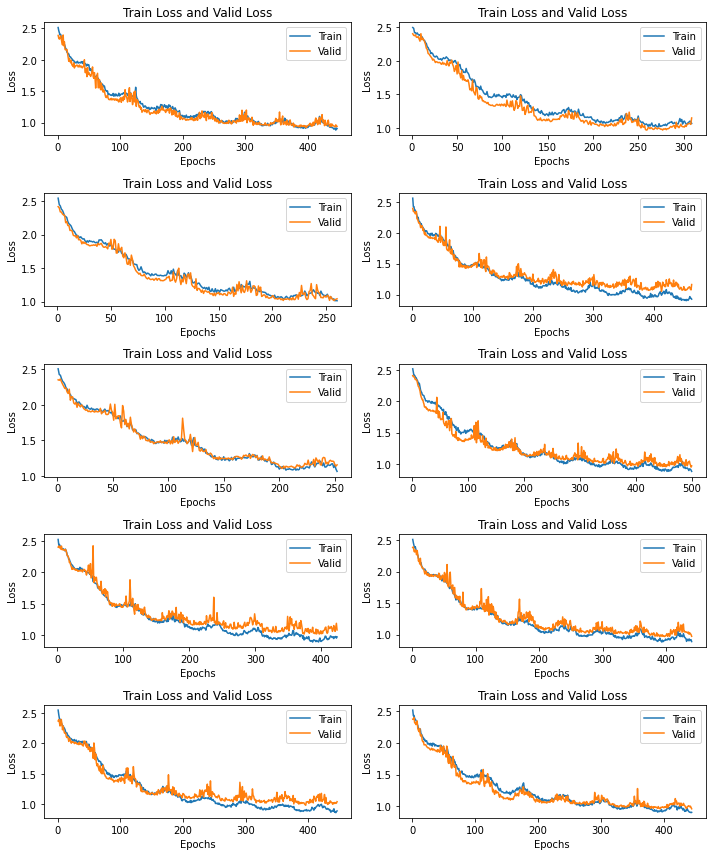

In [93]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(5, 2, figsize=(10, 12))
for i, ax in enumerate(axs.flatten()):
    show_loss_plot(net_epoch_train_loss[i], net_epoch_valid_loss[i], ax)
fig.tight_layout()

## test 예측

`-` softmax function을 취하면 11개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [38]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device) ## device는 전역변수
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD) ## N_FOLD는 전역변수
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값 

In [43]:
def TTA_predict(model: nn.Module, dataloader, weight_save_path, n_tta: int = 5) -> np.array:
    """
    test_time_augmentation(test에도 transform을 적용, 일반화 능력 향상)를 사용하여 dataloader의 데이터를 예측
    dataloader에는 transform이 적용된 dataset을 가지고 있어야 함
    n_tta 횟수만큼 predict를 반복한다
    이 과정에서 여러번(n_tta) 무작위로 transform이 적용된 images의 각 label별 확률값들의 평균을 계산 후 최대값을 가지는 label을 반환한다
    """
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수
    for i in tqdm(range(n_tta)):
        test_probs += (predict(net, test_dataloader, SAVE_PATH, is_prob=True) / n_tta)

    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스
    return test_preds ## 라벨값

In [40]:
test_dataset = CustomDataset(test_images, label_list=None, train_mode=False, transforms=get_transform(train_mode=True))  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
net = CNN().to(device)

In [44]:
pred = TTA_predict(net, test_dataloader, SAVE_PATH)

100%|██████████| 5/5 [05:09<00:00, 61.96s/it]


In [45]:
label_pred = label_encoding_inverse_transform(pd.Series(pred))

In [46]:
submission['label'] = label_pred
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8


In [47]:
submission.to_csv('./Data/submission_tta.csv', index=False)